# Assignment 3: Emotion Classification

Assignment 3 is set up as a Kaggle competition. The competition is not public so you need to click [here](https://www.kaggle.com/t/0c7e0344d8714ed7889126735a411aaf) to join it.

The task is to predict the emotions expressed in short text documents. You can find the training data (with the ground truth labels) and the test data (without the ground truth labels) in the folder `data` as well as on the [site](https://www.kaggle.com/competitions/cs5246-2320-assignment-4/) of the Kaggle competition. Apart from submitting your predictions to the competition, this assignment requires you to submit 2 deliverables to Canvas:

* **2-page report as PDF:** This report should include a short motivation and then outline the steps involved (e.g., data cleaning, data preprocessing, training, evaluation, discussion) in a clear and concise manner. Please use the same template as for the final report for the project; the template is available on Canvas. Please include you Kaggle user name, e.g., together with your name below the title!

* **Your source code as ZIP:** Please use the same folder containing this notebook to organize your source code and additional data file, if needed.

Please also add your NUSNET and Student ID in the code cell below. This is just to make any identification of your notebook doubly sure.

In [1]:
student_id = 'A0286188L'
nusnet_id = 'E1237250'
kaggle_user_id = 'Vishwanath Dattatreya Doddamani'

### Notebook Setup

In [2]:
import pandas as pd
import numpy as np

## Competition Dataset

The dataset used for this assignment is a subset of the [GoEmotions](https://ai.googleblog.com/2021/10/goemotions-dataset-for-fine-grained.html) dataset. To keep it simple and to reduce the overall dataset size, we have limited the data to documents/sentences annotated with only 5 out of [27 emotions](https://github.com/google-research/google-research/blob/master/goemotions/data/emotions.txt). More specifically, we only consider the emotions:

* anger
* love
* amusement
* disapproval
* gratitude

We performed some additional filter steps to reduce the overall dataset to 20k data samples, where 15k samples for the training data, and 5k samples for the test data. In the following, we have a quick look at the data.

### Training Data

#### Load Training Data from File

The training data is stored in file `data/train.csv`. This is a tab-separated file containing 3 columns:

* `Id`: Unique identifier of each training sample
* `Text`: Raw input text
* `Label`: Emotion label

In [3]:
df_train = pd.read_csv("data/train.csv", sep=",")

df_train.head()

,Id,Text,Label
0,0,What is this fucking r/niceguys bullshit?,anger
1,1,She has not laid her hands on her phone to cal...,disapproval
2,2,Please don't think the way they're trolling re...,gratitude
3,3,"Nice try, officer.",gratitude
4,4,Yes - thank you for stating it this way - perf...,gratitude


In [ ]:
print("Number of training samples: {}".format(len(df_train)))

Number of training samples: 7500


Let's visualize the distribution of class labels in form of a pie chart.

<Axes: >

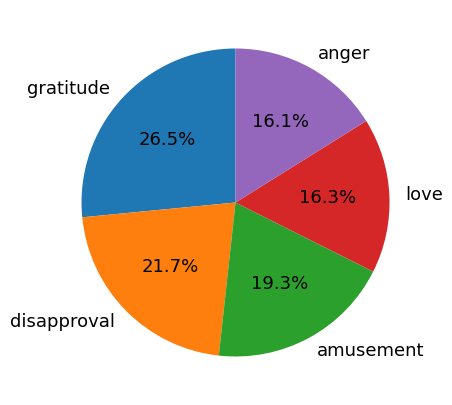

In [ ]:
kwargs = dict(
    startangle = 90,
    fontsize   = 13,
    figsize    = (60,5),
    autopct    = '%1.1f%%',
    label      = ''
)

df_train['Label'].value_counts().plot.pie(**kwargs)

In [4]:
import copy
data = copy.deepcopy(df_train)

While not perfectly distributed, the class labels are arguebly well balanced.

### Test Data

#### Load Test Data from File

The test data is stored in file `data/test.csv`. This is a tab-separated file containing 2 columns:

* `Id`: Unique identifier of each test sample
* `Text`: Raw input text

In [5]:
df_test = pd.read_csv("data/test.csv", sep=",")

df_test.head()

,Id,Text
0,0,i love this i am big fun of cross over and Lor...
1,1,FUCK LES BRUNS
2,2,Anyone who can pass the test proceeds. The sta...
3,3,yeah you're right. i just glanced over and tho...
4,4,I get abused on the daily fam


In [ ]:
print("Number of test samples: {}".format(len(df_test)))

Number of test samples: 2500


### Example Submission

#### Load Example Submission Data from File

The output on test data to submit is stored in file `data/example-submission.csv"`. This is a comma-separated file containing 2 columns:

* `Id`: Unique identifier; must match the identifier in test data
* `Predicted`: Predicted class labels

In [ ]:
df_example_submission = pd.read_csv("data/example-submission.csv", sep=",")

df_example_submission.head()

## Task: Emotion Prediction

Your task is to develop a classifier trained on the given emotion dataset. Using this classifier, you can then predict the class labels (i.e., emotions) for samples in the test set and upload your predictions to the Kaggle competition.

**Important:** For this assignment, please consider only classification models we have covered so far in the lecture, which includes:

* **K-Nearest Neighbor**
* **Naive Bayes**
* **Logistic Regression**
* **Basic Feedwordward NN (MLP)**
* **Convolutional NN (CNN)**
* **Recurrent NN (RNN)**

Also allowed are pretrained word embeddings. For example, you can find many such pretrained embeddings [here](http://vectors.nlpl.eu/repository/).

In [26]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn.functional as F
import numpy as np
import string

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

texts = data['Text'].tolist()  # Convert Text to List
labels = data['Label'].tolist()  # Corresponding labels for each text sample to List
texts_cleaned = [remove_punctuation(text.lower()) for text in texts]
# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# Split the data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts_cleaned, labels_encoded, test_size=0.2, random_state=42)

# Tokenize and encode the text data
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

# Convert the tokenized data to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)
val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels)
)

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-6)

# Define data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

best_model_state_dict = None
best_val_accuracy = 0  # Track best validation accuracy
best_val_loss = np.inf  # Track best validation loss
early_stopping_patience = 3  # Number of epochs to wait for early stopping
early_stopping_counter = 0
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []


#Training
for epoch in range(100):  # Change the number of epochs as needed
    model.train()
    train_losses = []
    train_preds = []
    train_true = []

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs.logits, axis=1)
        train_preds.extend(preds.cpu().numpy())
        train_true.extend(labels.cpu().numpy())

    train_accuracy = accuracy_score(train_true, train_preds)
    avg_train_loss = np.mean(train_losses)

    # Validation
    model.eval()
    val_preds = []
    val_true = []
    val_losses = []

    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        loss = F.cross_entropy(logits, labels)
        val_losses.append(loss.item())

        preds = torch.argmax(logits, axis=1)
        val_preds.extend(preds.cpu().numpy())
        val_true.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_true, val_preds)
    avg_val_loss = np.mean(val_losses)

    print(f'Epoch {epoch + 1}: Training Accuracy: {train_accuracy:.4f}, Training Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}')
    training_losses.append(avg_train_loss)
    validation_losses.append(avg_val_loss)
    training_accuracies.append(train_accuracy)
    validation_accuracies.append(val_accuracy)
    # Update best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state_dict = model.state_dict()
        early_stopping_counter = 0
        print('New Best Model')
    else:
        early_stopping_counter += 1

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        
    #Early Stopping
    if early_stopping_counter >= early_stopping_patience:
        print('Early stopping triggered.')
        break




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Training Accuracy: 0.2730, Training Loss: 1.5840, Validation Accuracy: 0.3893, Validation Loss: 1.4837
New Best Model
Epoch 2: Training Accuracy: 0.4365, Training Loss: 1.4230, Validation Accuracy: 0.4833, Validation Loss: 1.3386
New Best Model
Epoch 3: Training Accuracy: 0.4987, Training Loss: 1.3072, Validation Accuracy: 0.5120, Validation Loss: 1.2382
New Best Model
Epoch 4: Training Accuracy: 0.5377, Training Loss: 1.2125, Validation Accuracy: 0.5573, Validation Loss: 1.1534
New Best Model
Epoch 5: Training Accuracy: 0.5915, Training Loss: 1.1261, Validation Accuracy: 0.6027, Validation Loss: 1.0724
New Best Model
Epoch 6: Training Accuracy: 0.6435, Training Loss: 1.0500, Validation Accuracy: 0.6533, Validation Loss: 0.9966
New Best Model
Epoch 7: Training Accuracy: 0.6778, Training Loss: 0.9740, Validation Accuracy: 0.6893, Validation Loss: 0.9327
New Best Model
Epoch 8: Training Accuracy: 0.7052, Training Loss: 0.9077, Validation Accuracy: 0.7253, Validation Loss: 0.8648

<h3>Model Evaluation</h3>

In [28]:
# Load best model state_dict
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))
model.load_state_dict(best_model_state_dict)
model.eval()
model.to(device)
# Evaluate on validation set
val_preds = []
val_true = []
for batch in val_loader:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    preds = torch.argmax(logits, axis=1)
    val_preds.extend(preds.cpu().numpy())
    val_true.extend(labels.cpu().numpy())
val_preds = le.inverse_transform(val_preds)
val_true = le.inverse_transform(val_true)
# Print classification report
print(classification_report(val_true, val_preds))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


              precision    recall  f1-score   support

   amusement       0.79      0.81      0.80       297
       anger       0.75      0.74      0.75       236
 disapproval       0.80      0.77      0.79       346
   gratitude       0.93      0.92      0.93       368
        love       0.86      0.90      0.88       253

    accuracy                           0.83      1500
   macro avg       0.83      0.83      0.83      1500
weighted avg       0.83      0.83      0.83      1500



<h3>Plotting Performace Metrics</h3>

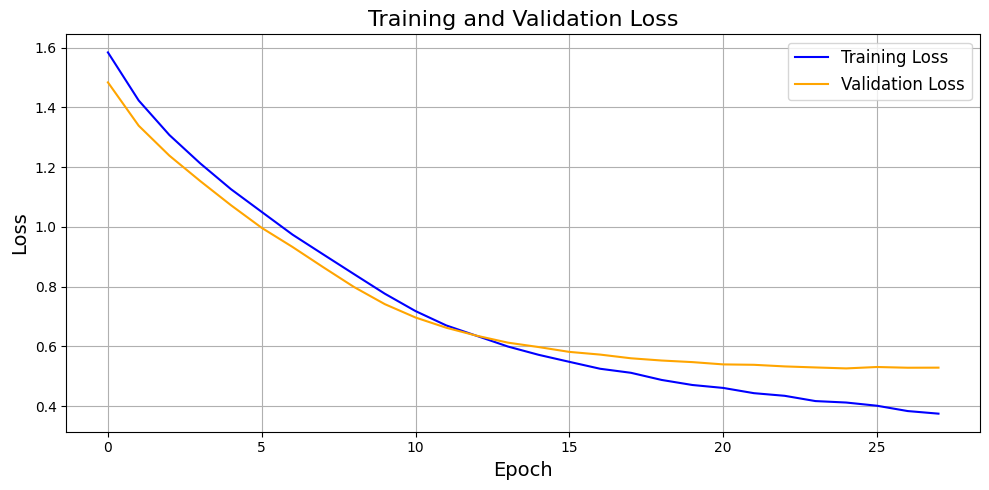

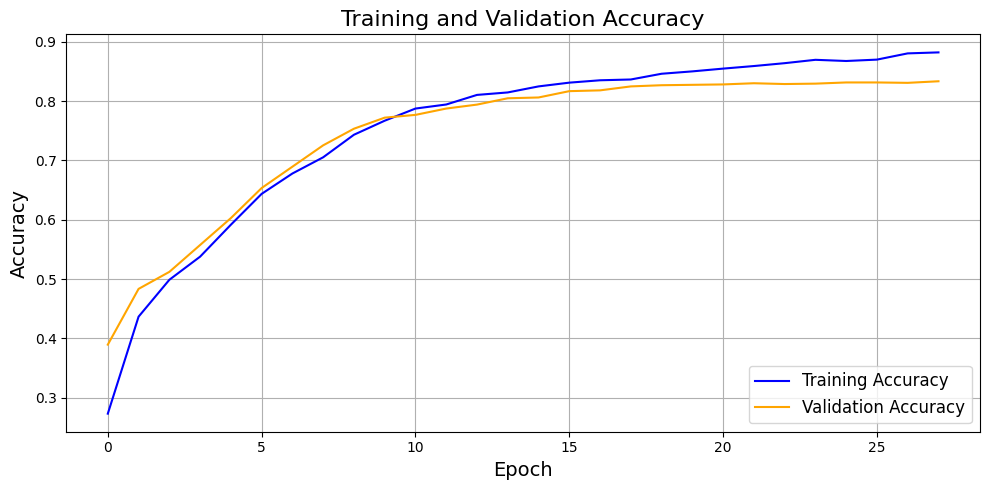

In [30]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss', color='blue')
plt.plot(validation_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss', fontsize=16)
plt.grid(True)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(training_accuracies, label='Training Accuracy', color='blue')
plt.plot(validation_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy', fontsize=16)
plt.grid(True)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()


<h3>Writing Output to example-submission using test dataset</h3>

In [11]:
import torch

# Tokenize and encode the test data
test_texts = df_test['Text'].tolist()
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

# Convert the tokenized data to PyTorch tensors
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask'])
)

# Define a data loader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8)

# Evaluate the model on the test set
model.eval()
test_preds = []

for batch in test_loader:
    input_ids, attention_mask = batch
    input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    preds = torch.argmax(logits, axis=1)
    test_preds.extend(preds.cpu().numpy())

# Decode the predicted labels
predicted_labels = le.inverse_transform(test_preds)

# Add predicted labels to the DataFrame
df_test['predicted_label'] = predicted_labels

# Display the DataFrame with predicted labels
print(df_test.head())


   Id                                               Text predicted_label
0   0  i love this i am big fun of cross over and Lor...            love
1   1                                     FUCK LES BRUNS           anger
2   2  Anyone who can pass the test proceeds. The sta...     disapproval
3   3  yeah you're right. i just glanced over and tho...       amusement
4   4                     I get abused on the daily fam        amusement


In [12]:
df_test['Predicted'] = df_test['predicted_label']
df_test.head()

,Id,Text,predicted_label,Predicted
0,0,i love this i am big fun of cross over and Lor...,love,love
1,1,FUCK LES BRUNS,anger,anger
2,2,Anyone who can pass the test proceeds. The sta...,disapproval,disapproval
3,3,yeah you're right. i just glanced over and tho...,amusement,amusement
4,4,I get abused on the daily fam,amusement,amusement


In [13]:
df_test[['Id', 'Predicted']].to_csv('data/example-submission.csv', index = False)